In [81]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2

from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras import Sequential
from keras.optimizers import Adam
from keras.layers import Flatten, Dense
from keras.losses import CategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
import keras


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
#         print(os.path.join(dirname, filename))

In [56]:
# Loading the dataset
train_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Train'
test_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Test'
val_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation'

In [57]:
# Data augmentation
train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.25,shear_range=0.25)
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(128,128),
    class_mode='categorical',
    batch_size=32
)

val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = train_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(128,128),
    class_mode='categorical',
    batch_size=32
)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = train_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(128,128),
    class_mode='categorical',
    batch_size=32
)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [64]:
vgg = VGG19(weights='imagenet',include_top= False, input_shape = (128,128,3))

for layer in vgg.layers:
    layer.trainable = False

model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(16,activation='sigmoid'))
model.add(Dense(2,activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                131088    
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 34        
Total params: 20,155,506
Trainable params: 131,122
Non-trainable params: 20,024,384
_________________________________________________________________


In [65]:
loss = CategoricalCrossentropy()

lr = 1e-3
optimizer = Adam(
    lr
)

model.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")

In [66]:
history = model.fit(train_generator,
                              steps_per_epoch=len(train_generator)//32,
                              epochs=30,validation_data=val_generator,
                              validation_steps=len(val_generator)//32
                   )

Epoch 1/30
9/9 [==============================] - 14s 1s/step - loss: 0.6819 - accuracy: 0.6227
Epoch 2/30
9/9 [==============================] - 13s 1s/step - loss: 0.4113 - accuracy: 0.8664
Epoch 3/30
9/9 [==============================] - 13s 1s/step - loss: 0.3789 - accuracy: 0.8518
Epoch 4/30
9/9 [==============================] - 13s 1s/step - loss: 0.2535 - accuracy: 0.9283
Epoch 5/30
9/9 [==============================] - 13s 1s/step - loss: 0.1830 - accuracy: 0.9619
Epoch 6/30
9/9 [==============================] - 13s 1s/step - loss: 0.1785 - accuracy: 0.9710
Epoch 7/30
9/9 [==============================] - 13s 1s/step - loss: 0.1691 - accuracy: 0.9576
Epoch 8/30
9/9 [==============================] - 13s 1s/step - loss: 0.1243 - accuracy: 0.9766
Epoch 9/30
9/9 [==============================] - 13s 1s/step - loss: 0.1345 - accuracy: 0.9675
Epoch 10/30
9/9 [==============================] - 13s 1s/step - loss: 0.1563 - accuracy: 0.9413
Epoch 11/30
9/9 [======================

dict_keys(['loss', 'accuracy'])


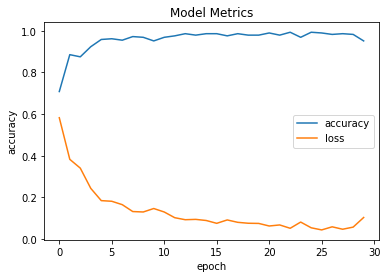

In [67]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model Metrics')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='center right')
plt.show()

In [73]:
model.evaluate(test_generator)

25/25 [==============================] - 36s 1s/step - loss: 0.0723 - accuracy: 0.9775


[0.07229060679674149, 0.9775000214576721]

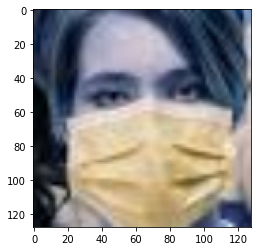

In [76]:
sample_mask_img = cv2.imread('../input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithMask/1389.png')
sample_mask_img = cv2.resize(sample_mask_img,(128,128))
plt.imshow(sample_mask_img)
sample_mask_img = np.reshape(sample_mask_img,[1,128,128,3])
sample_mask_img = sample_mask_img/255.0

In [78]:
model.predict(sample_mask_img)

array([[0.68419665, 0.12966308]], dtype=float32)

In [79]:
model.save("face_mask_detector.h5")

## Face Detection using haarcascades

Here we load the detection model and use it to detect faces in an image with people

If we find people, we crop out the faces and run them through our predictor

If the person is wearing a mask, the label will show as such.


In [92]:
#loading face detection model
face_model = cv2.CascadeClassifier('../input/haarcascades/haarcascade_frontalface_default.xml')

In [83]:
model = keras.models.load_model("face_mask_detector.h5")

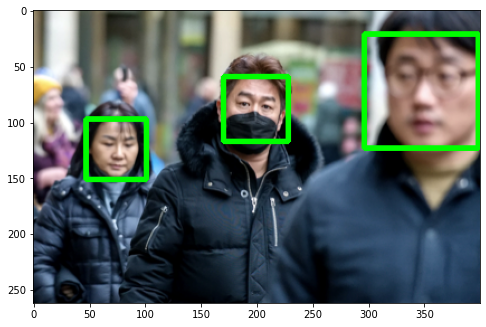

In [107]:
input_image = cv2.imread('../input/face-mask-detection/images/maksssksksss244.png')
input_image = cv2.cvtColor(input_image, cv2.IMREAD_GRAYSCALE)
faces = face_model.detectMultiScale(input_image,scaleFactor=1.1, minNeighbors=4) #returns a list of (x,y,w,h) tuples

output = cv2.cvtColor(input_image, cv2.COLOR_RGB2BGR) #colored output image

#plotting
for (x,y,w,h) in faces:
    cv2.rectangle(output,(x,y),(x+w,y+h),(0,255,0),3)
plt.figure(figsize=(8,8))
plt.imshow(output)

In [108]:
mask = {0:('MASK',(0,255,0)),1:('NO MASK',(255,0,0))}

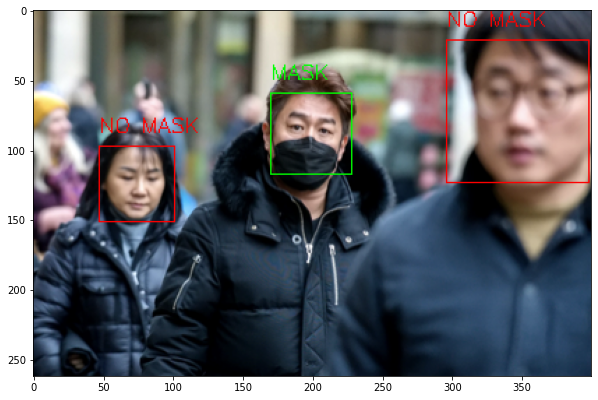

In [109]:
if len(faces)>=1:
    output_image = cv2.cvtColor(input_image,cv2.COLOR_RGB2BGR)
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = output_image[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])
        crop = crop/255.0
        mask_prediction = model.predict(crop)
        cv2.putText(output_image,mask[mask_prediction.argmax()][0],(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,mask[mask_prediction.argmax()][1],1)
        cv2.rectangle(output_image,(x,y),(x+w,y+h),mask[mask_prediction.argmax()][1],1)
else:
    print("No faces found in the image")

plt.figure(figsize=(10,10))
plt.imshow(output_image)
    